In [1]:
!pip install kaggle opendatasets tensorflow tensorflow-addons keras opencv-python tqdm

In [3]:
import tensorflow as tf
import keras
import numpy as np
import os
import cv2
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import warnings
import opendatasets as od
import pandas as pd
warnings.filterwarnings("ignore", category=DeprecationWarning)  #Ignores all Deprecation warnings
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, concatenate, Activation, Flatten, Dense, BatchNormalization , UpSampling2D

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
#Downloading Dataset from Kaggle
od.download("https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 8bb203712d6ec3eda7463f396d1b28e3
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation


100%|██████████| 616M/616M [00:04<00:00, 130MB/s]


### **Dice Loss**

Defining a fucntion to calculate the Dice Loss

**Dice loss**, also known as the Sørensen-Dice coefficient or F1 score, is a loss function commonly used in image segmentation tasks to measure the dissimilarity between the predicted segmentation and the ground truth.

The dice loss measures the similarity between the predicted segmentation mask and the ground truth mask.




In [4]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5                                 #used to avoid division by zero
    #Typecasting the Data to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    #calculates the intersection between the y_true and y_pred tensors
    intersection = tf.reduce_sum(y_true * y_pred)

    #calculates the union of the y_true and y_pred tensors
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    return loss

In [5]:
dataset_dir1 = '/content/people-clothing-segmentation/png_images/IMAGES'
dataset_dir2 = '/content/people-clothing-segmentation/png_masks/MASKS'

images = []
masks = []

# Iterate through each image file
for filename in os.listdir(dataset_dir1):
    mask_name = "seg_"+filename[4:]

    image = cv2.imread(os.path.join(dataset_dir1, filename))
    mask = cv2.imread(os.path.join(dataset_dir2, mask_name))

    image = cv2.resize(image, (512, 512,))
    mask = cv2.resize(mask, (512, 512,))

    images.append(image)
    masks.append(mask)

image_train = np.array(images)
mask_train = np.array(masks)

In [6]:
print("The shape of the Masks in the training Data:{})".format(mask_train.shape))

The shape of the Masks in the training Data:(1000, 512, 512, 3))


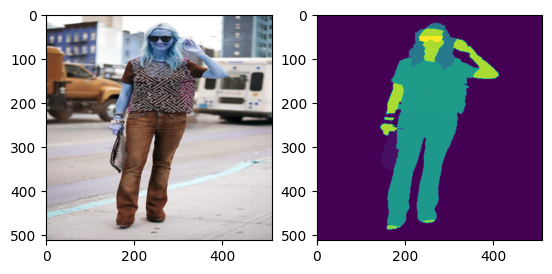

In [7]:
plt.subplot(1,2,1)
plt.imshow(image_train[56])

plt.subplot(1,2,2)
plt.imshow(mask_train[56][:,:,0])

plt.show()

In [8]:
image_data_type = image_train.dtype
print("Image data type:", image_data_type)
print(image_train.shape)

mask_data_type = mask_train.dtype
print("Mask data type:", mask_data_type)
print(mask_train.shape)

Image data type: uint8
(1000, 512, 512, 3)
Mask data type: uint8
(1000, 512, 512, 3)


In [9]:
masked_image = cv2.bitwise_and(image_train, image_train, mask=mask_train)

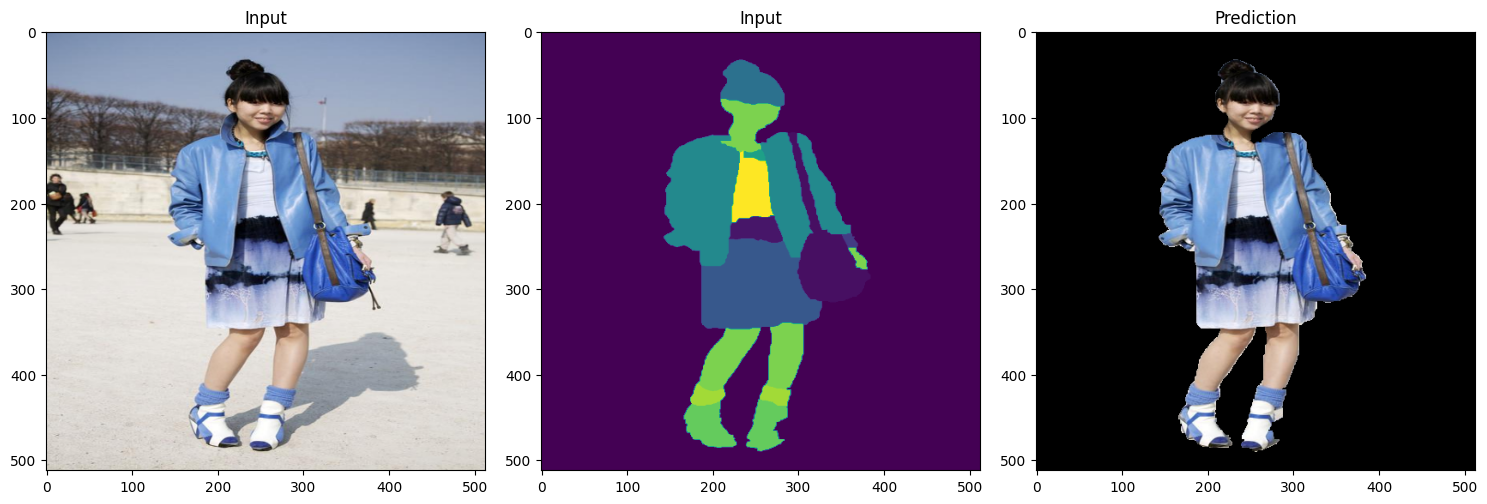

In [10]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_train1 = cv2.cvtColor(image_train[29], cv2.COLOR_BGR2RGB)
plt.imshow(x_train1)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
plt.imshow(mask_train[29][:,:,0])
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
rgb_image = cv2.cvtColor(masked_image[29], cv2.COLOR_BGR2RGB)

# Display the RGB image using Matplotlib
plt.imshow(rgb_image)
plt.title('Prediction')

plt.tight_layout()
plt.show()

In [11]:
class MultiLayerPerceptron():

    def __init__(self, input):
        super().__init__()
        self.inp = input

        self.conv_relu = Conv2D(1, kernel_size=3, strides=(1, 1), padding='SAME', activation='relu')
        self.conv = Conv2D(1, kernel_size=3, strides=(1, 1), padding='SAME')
        self.out = self.MLP()

    def MLP(self):
        out = self.conv_relu(self.inp)
        out = self.conv(self.inp)
        return out


In [12]:
class ConvBlockAttentionModule():

  def __init__(self,input) :
    self.out = self.CBAM(input)


  def CBAM(self,input):

    max1 = tf.reduce_max(input,axis=-1,keepdims = True)
    avg1 = tf.reduce_mean(input,axis=-1,keepdims = True)
    max1 = MultiLayerPerceptron(max1).out
    avg1 = MultiLayerPerceptron(avg1).out

    cam = tf.add(max1,avg1)
    cam = tf.keras.activations.sigmoid(cam)
    out1 = tf.math.multiply(cam,input)

    max2 = MaxPooling2D(pool_size = (2,2), strides = 1, padding = 'SAME')(out1)
    # print(np.shape(max2))
    avg2 = AveragePooling2D(pool_size = (2,2), strides = 1, padding = 'SAME')(out1)
    # print(np.shape(avg2))
    out2 = tf.concat([avg2,max2],axis = -1)
    # print(np.shape(out2))
    out2 = Conv2D(1,kernel_size=3,strides=(1,1), padding= 'same')(out2)
    # print(np.shape(out2))
    out2 = tf.keras.activations.sigmoid(out2)
    # print(np.shape(out2))

    out = tf.math.multiply(out1,out2)

    return out

In [13]:
class DownSampling():

  def __init__(self,input,n_filters):
    # super().__init__()
    self.inp = input
    self.nf = n_filters
    self.skip = self.Down_skip()
    self.output = self.Down_out()

  def Down_out(self) :

    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(self.inp)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)
    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(out)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)
    avg = AveragePooling2D(pool_size=(2,2),strides = 2, padding = 'valid')(out)

    # output = ConvBlockAttentionModule(avg).out
    output = avg

    return output

  def Down_skip(self) :

    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(self.inp)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)
    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(out)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)

    return out

In [14]:
tf.keras.layers.UpSampling2D(
    size=(2,2), data_format=None , interpolation ='bilinear'
)

In [15]:
class UpSampling():

  def __init__(self,input,skip,n_filters):
    # super().__init__()
    self.inp = input
    self.sk = skip
    self.nf = n_filters
    self.out = self.UpS();

  def UpS(self) :

    up = UpSampling2D(size=(2, 2), interpolation="bilinear")(self.inp)
    up = Conv2D(self.nf, kernel_size=3, activation="relu", padding="same")(up)
    up = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(up)
    up = BatchNormalization(axis=-1)(up)
    up = tf.keras.layers.LeakyReLU(alpha = 0.2)(up)
    up = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(up)
    up = BatchNormalization(axis=-1)(up)
    up = tf.keras.layers.LeakyReLU(alpha = 0.2)(up)

    # out = ConvBlockAttentionModule(up).out
    out = up

    out = concatenate([out,self.sk], axis = 3)

    return out

In [16]:
class ResidualBlock():

  def __init__(self,input,n_filters):
    # super().__init__()
    self.inp = input
    self.nf = n_filters
    self.out = self.Residual();

  def Residual (self) :

    res = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(self.inp)
    res = BatchNormalization(axis=-1)(res)
    res = tf.keras.layers.LeakyReLU()(res)
    res = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(res)
    res = BatchNormalization(axis=-1)(res)

    out = tf.keras.layers.Add()([res,self.inp])

    out = tf.keras.layers.ReLU()(out)

    # out = ConvBlockAttentionModule(out).out

    return out

In [17]:
class UNet_Model():

  def __init__(self,input_size,n_filters=4,n_classes = 59):
    # super().__init__()
    self.inps = input_size
    self.nf = n_filters
    self.nc = n_classes
    self.model = self.UNet();


  def UNet(self) :

    inputs = Input(self.inps)

    down1 = DownSampling(inputs,self.nf)
    down2 = DownSampling(down1.output,self.nf*2)
    down3 = DownSampling(down2.output,self.nf*4)
    down4 = DownSampling(down3.output,self.nf*8)
    down5 = DownSampling(down4.output,self.nf*16)

    res1 = ResidualBlock(down5.output,self.nf*16)
    res2 = ResidualBlock(res1.out,self.nf*16)
    res3 = ResidualBlock(res2.out,self.nf*16)
    res4 = ResidualBlock(res3.out,self.nf*16)

    up1 = UpSampling (res4.out,down5.skip,self.nf*16)
    up2 = UpSampling (up1.out,down4.skip,self.nf*8)
    up3 = UpSampling (up2.out,down3.skip,self.nf*4)
    up4 = UpSampling (up3.out,down2.skip,self.nf*2)
    up5 = UpSampling (up4.out,down1.skip,self.nf)

    final = Conv2D(self.nc,1,padding = 'same')(up5.out)
    model = tf.keras.Model(inputs=inputs,outputs=final)

    return model

In [18]:
#from keras.optimizers import SGD

#sgd = SGD(lr=0.001, momentum=0.9)

u = UNet_Model((512,512,3)).model
u.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
u.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 512, 512, 4)          112       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 512, 512, 4)          16        ['conv2d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)   (None, 512, 512, 4)          0         ['batch_normalization_2[0]

In [19]:
np.shape(mask_train[1])

(512, 512, 3)

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [21]:
masks_train = np.expand_dims(mask_train[:,:,:,0], axis =-1)
masks_train.shape

(1000, 512, 512, 1)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# image_train, image_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.1, random_state=42)

# train_dataset = tf.data.Dataset.from_tensor_slices((image_train, mask_train)).batch(15)
# test_dataset = tf.data.Dataset.from_tensor_slices((image_test, mask_test)).batch(15)
train_dataset = tf.data.Dataset.from_tensor_slices((image_train[0:900], masks_train[0:900]))
train_dataset = train_dataset.batch(15)
test_dataset = tf.data.Dataset.from_tensor_slices((image_train[901:1000], masks_train[901:1000]))
test_dataset = test_dataset.batch(15)

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
u.load_weights("content/A100_Seg_model_ckpt/model.ckpt")

In [25]:
checkpoint_path = "content/A100_Seg_model_ckpt/model.ckpt"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

history = u.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[checkpoint])

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 3.8106 - accuracy: 0.2736
Epoch 1: val_loss improved from inf to 3.38425, saving model to content/A100_Seg_model_ckpt/model.ckpt
60/60 [==============================] - 42s 205ms/step - loss: 3.8106 - accuracy: 0.2736 - val_loss: 3.3843 - val_accuracy: 0.6505
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 3.2867 - accuracy: 0.6553
Epoch 2: val_loss improved from 3.38425 to 2.94049, saving model to content/A100_Seg_model_ckpt/model.ckpt
60/60 [==============================] - 10s 163ms/step - loss: 3.2867 - accuracy: 0.6553 - val_loss: 2.9405 - val_accuracy: 0.6821
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 2.6724 - accuracy: 0.6872
Epoch 3: val_loss improved from 2.94049 to 2.37297, saving model to content/A100_Seg_model_ckpt/model.ckpt
60/60 [==============================] - 10s 163ms/step - loss: 2.6724 - accuracy: 0.6872 - val_loss: 2.3730 - val_accuracy: 0.7357
Epoch

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
